In [41]:
import os
import polars as pl
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline

In [42]:
dataroot = Path("./assets/preprocessed")
#train_path = dataroot / "Train_nus-wide.ndjson"
test_path = dataroot / "Test_nus-wide.ndjson"

In [43]:
test = pl.read_ndjson(test_path)
tsample = test
#tsample = tsample.filter(pl.col("tags").list.len() > 3)
tsample = tsample.sample(4, seed=10)
tsample.glimpse()

Rows: 4
Columns: 4
$ file_name        <str> '0328_2155355745.jpg', '0334_399568693.jpg', '0230_911420590.jpg', '0503_2231687616.jpg'
$ labels     <list[str]> ['snow'], ['person'], ['person'], ['buildings', 'clouds', 'nighttime', 'reflection', 'water']
$ tags       <list[str]> ['explore', 'winter', 'interestingness', 'snow', 'canada', 'old', 'barn'], ['meeting', 'collage'], ['blue', 'orange', 'girl', 'woman', 'rock', 'sign', 'fashion', 'door', 'hand', 'hair', 'amazing', 'style', 'standing'], ['water', 'night', 'city', 'travel', 'reflection', 'europe', 'river', 'england', 'old', 'london', 'bridge', 'war', 'downtown', 'museum', 'photographer', 'navy', 'british', 'gun', 'nice']
$ image_root       <str> './assets/nus-wide/images', './assets/nus-wide/images', './assets/nus-wide/images', './assets/nus-wide/images'



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 25.11it/s]


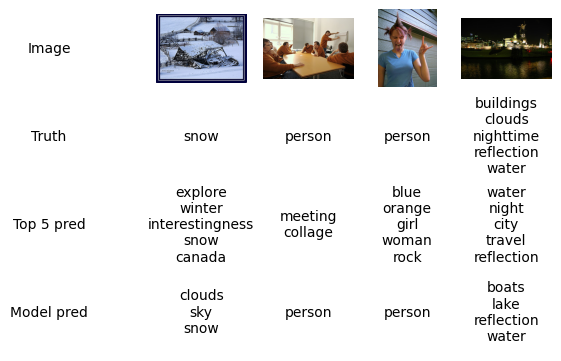

In [44]:
from scripts.test.compose import trainer, model, data
os.environ["SPECIFIC_IMGS"] = ",".join(tsample["file_name"])

alignment = {"verticalalignment": "center", "horizontalalignment": "center"}

preds = trainer.predict(model, datamodule=data)
fig, axs = plt.subplots(ncols=5, nrows=4, figsize=(5.5, 3.5), layout="constrained")
for ax in axs.ravel():
    ax.set_axis_off()
for i, txt in enumerate(["Image", "Truth", "Top 5 pred", "Model pred"]):
    axs[i,0].text(0, 0.5, txt, **alignment)
for i, path in enumerate(tsample["file_name"]):
    img_path = Path(tsample["image_root"][i], path)
    img = plt.imread(img_path)
    axs[0,i+1].imshow(img)
    axs[1,i+1].text(0.5, 0.5, "\n".join(tsample["labels"][i]), **alignment)
    axs[2,i+1].text(0.5, 0.5, "\n".join(tsample["tags"][i][:5]), **alignment)
    axs[3,i+1].text(0.5, 0.5, "\n".join(preds[0][i] if len(preds[0][i]) > 0 else ["-"]), **alignment)